<a href="https://colab.research.google.com/github/afnanetman/Head-Pose-Estimation/blob/main/Head_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install mediapipe

In [3]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,f1_score
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import xgboost as xg


In [13]:
path = '/content/drive/MyDrive/AFLW2000-3D.zip'

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#%%capture
if os.path.isfile('/content/drive/MyDrive/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
!unzip /content/drive/MyDrive/AFLW2000-3D.zip

Archive:  /content/drive/MyDrive/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  in

## Data Extraction And Preparation

In [30]:
def getLandMarks(name,img,path=None):
  # choosing random image
  random_file = name
  Xs=[]
  Ys=[]

  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      if(path!=None) :
        image = cv2.imread(path+random_file+'.jpg')
      else :  image = img
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
     

      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            center_x = face.landmark[4].x * image.shape[1]
            center_y = face.landmark[4].y * image.shape[0]
            x_10 = face.landmark[10].x * image.shape[1]
            y_10 = face.landmark[10].y * image.shape[0]
            distance = np.linalg.norm(np.array((x_10, y_10)) - np.array((center_x, center_y)))
            for landmark in face.landmark:
                x = (landmark.x * image.shape[1] - center_x) / distance
                y = (landmark.y * image.shape[0] - center_y) / distance
                Xs.append(x)
                Ys.append(y)
      return(Xs,Ys)



In [31]:
def drawPoints(name,path='/content/AFLW2000/'):
  # choosing random image
  random_file = name

  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread(path+random_file+'.jpg')
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
        cv2_imshow(image)

In [32]:
def draw_axis(pitch,yaw,roll,img,name=None,path='/content/drive/MyDrive/Head-pose tests/', tdx=None, tdy=None, size = 100):
    faceModule = mediapipe.solutions.face_mesh
    faces = faceModule.FaceMesh(static_image_mode=True)
    if(name!=None):
      img = cv2.imread(path+name+'.jpg')
    yaw = -yaw

    results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    tdx = int(results.multi_face_landmarks[0].landmark[4].x * img.shape[1])
    tdy = int(results.multi_face_landmarks[0].landmark[4].y * img.shape[0])

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    
    return img



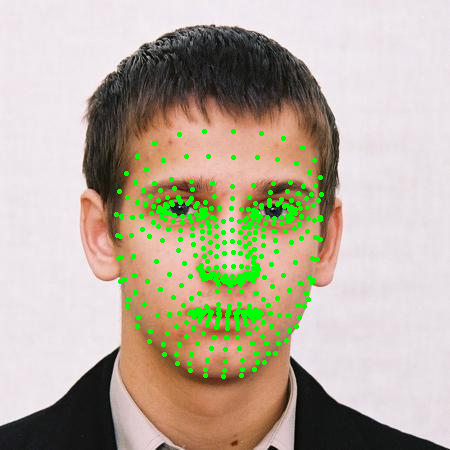

In [33]:
drawPoints('image00053')

In [34]:
def drawPos(name,customPose=None,path='/content/AFLW2000/'):
  random_file = name
  image = cv2.imread(path+random_file+'.jpg')
  # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
  # extracting the labels 3 angels
  if (customPose!=None) : pose_para=customPose
  else : 
    mat_file = sio.loadmat(path+random_file+'.mat')
    pose_para = mat_file["Pose_Para"][0][:3]
  pitch = pose_para[0]
  yaw = pose_para[1]
  roll = pose_para[2]
  cv2_imshow(draw_axis(pitch,yaw,roll,img=image))

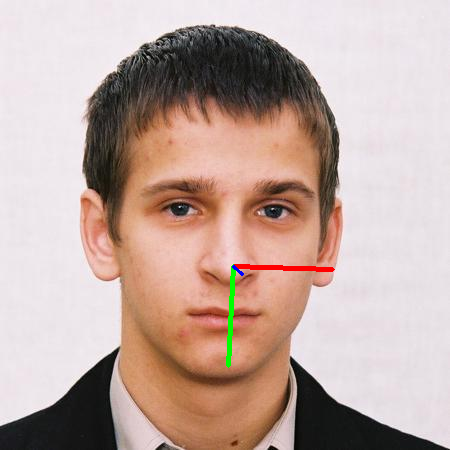

In [35]:
drawPos('image00053')

In [36]:
mylist = [f for f in glob.glob("/content/AFLW2000/*.mat")]

In [37]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines

In [38]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [39]:
class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        labels = pose[:3]
        cont_labels = [yaw, pitch, roll]

        # if self.transform is not None:
        #     img = self.transform(img)
        # return cont_labels
        return img, labels, cont_labels, self.X_train[index]

    def __len__(self):
        #self.length = 2000
        return self.length

In [40]:
demo=AFLW2000("/content/AFLW2000/*.mat",'/content/AFLW2000/')

get yaw, pitch, roll for all images

In [41]:
labels=[]
imgs=[]
for i in range(demo.length):
  pla=demo.__getitem__(i)
  x = np.array(pla[1], dtype=np.float32)
  labels.append(x)
  imgs.append(pla[3])


In [42]:
df = pd.DataFrame(labels,columns=['yaw', 'pitch', 'roll'],index=imgs) #convert to a dataframe

In [43]:
df.head()

yaw     pitch      roll
image00002 -0.399231  0.018227  0.085676
image00004  0.470065  1.189533  0.300959
image00006 -0.184650  0.881137 -0.236852
image00008 -0.175379  0.299208 -0.373374
image00010 -0.882169  1.198004 -1.033374

In [44]:
filenames = get_list_from_filenames('/content/AFLW2000/*.mat')

In [45]:
filenames.sort()

get landmarks for all images

In [46]:
len(getLandMarks(filenames[2],None,path='/content/AFLW2000/')[1])

468

In [47]:
landmarksX = []
landmarksY = []
for i in filenames :
  landmarks = getLandMarks(i,None,path='/content/AFLW2000/')
  #print(sum(landmarks[0]),sum(landmarks[1]))
  landmarksX.append(landmarks[0])
  landmarksY.append(landmarks[1])
  # np.append(landmarksX,landmarks[0])
  # np.append(landmarksY,landmarks[1])

In [48]:
X = pd.DataFrame(landmarksX,columns=["x"+str(i) for i in range(1,469)],index=filenames)

In [49]:
Y = pd.DataFrame(landmarksY,columns=["y"+str(i) for i in range(1,469)],index=filenames)

merge all information in one dataset

In [50]:
data = pd.concat([X,Y,df],axis=1)

In [51]:
data.head()

x1        x2        x3        x4   x5        x6        x7  \
image00002 -0.015016 -0.004175 -0.002313 -0.033131  0.0  0.009408  0.038658   
image00004  0.128808  0.007585  0.165518  0.101251  0.0  0.055152  0.242372   
image00006 -0.030356 -0.001089 -0.026057 -0.086177  0.0 -0.009169 -0.042326   
image00008  0.161236  0.029694  0.106103 -0.066240  0.0 -0.017747 -0.039749   
image00010       NaN       NaN       NaN       NaN  NaN       NaN       NaN   

                  x8        x9       x10  ...      y462      y463      y464  \
image00002 -0.388208  0.055289  0.061224  ...  0.070584  0.071116 -0.416344   
image00004  0.243431  0.292045  0.281744  ...  0.117034  0.139618 -0.350272   
image00006 -0.615660 -0.056243 -0.057683  ...  0.091510  0.098864 -0.414680   
image00008 -0.383064 -0.092182 -0.128882  ...  0.054681  0.056162 -0.522544   
image00010       NaN       NaN       NaN  ...       NaN       NaN       NaN   

                y465      y466      y467      y468       yaw     pitch  \
image00002 -0.392857 -0.369731 -0.458569 -0.480998 -0.399231  0.018227   
image00004 -0.326416 -0.310461 -0.383852 -0.408154  0.470065  1.189533   
image00006 -0.389199 -0.368688 -0.453836 -0.480969 -0.184650  0.881137   
image00008 -0.485652 -0.454885 -0.695945 -0.737958 -0.175379  0.299208   
image00010       NaN       NaN       NaN       NaN -0.882169  1.198004   

                roll  
image00002  0.085676  
image00004  0.300959  
image00006 -0.236852  
image00008 -0.373374  
image00010 -1.033374  

[5 rows x 939 columns]

In [52]:
data.shape

(2000, 939)

drop null values caused by media pipe

In [53]:
data.isnull().sum()

x1       147
x2       147
x3       147
x4       147
x5       147
        ... 
y467     147
y468     147
yaw        0
pitch      0
roll       0
Length: 939, dtype: int64

In [54]:
data.dropna(inplace=True)

In [55]:
data.shape

(1853, 939)

Apply PCA to reduce dimensionality

In [56]:
pca = PCA(n_components = 0.95)
data_pca = pd.DataFrame(pca.fit_transform(data.iloc[:,:-3]),index=data.index)
data_pca.head()

0         1         2         3
image00002 -0.514852 -1.009354 -2.389395 -1.433828
image00004 -9.721284 -1.553301 -0.591900  2.152778
image00006  1.990843  0.155226  0.123936 -1.379687
image00008 -3.385142  3.574856 -2.557032 -1.873590
image00013 -0.815008  2.307663  1.005834 -0.083830

In [57]:
data_pca=pd.concat((data_pca,data.iloc[:,:-4:-1]),axis=1)
data_pca.head()

0         1         2         3      roll     pitch  \
image00002 -0.514852 -1.009354 -2.389395 -1.433828  0.085676  0.018227   
image00004 -9.721284 -1.553301 -0.591900  2.152778  0.300959  1.189533   
image00006  1.990843  0.155226  0.123936 -1.379687 -0.236852  0.881137   
image00008 -3.385142  3.574856 -2.557032 -1.873590 -0.373374  0.299208   
image00013 -0.815008  2.307663  1.005834 -0.083830 -0.220662  0.011965   

                 yaw  
image00002 -0.399231  
image00004  0.470065  
image00006 -0.184650  
image00008 -0.175379  
image00013 -0.026812

## Model Training 

#### Train model on data before PCA

In [58]:
train,test = train_test_split(data,test_size=0.2,random_state=42)

In [59]:
model = MultiOutputRegressor(AdaBoostRegressor(n_estimators=60,learning_rate=0.3))
model.fit(train.iloc[:,:-3],train.iloc[:,:-4:-1])

MultiOutputRegressor(estimator=AdaBoostRegressor(learning_rate=0.3,
                                                 n_estimators=60))

In [60]:
preds = model.predict(test.iloc[:,:-3])

In [61]:
r2_score(test.iloc[:,:-4:-1],preds)

-4.636114603260626

draw original poses

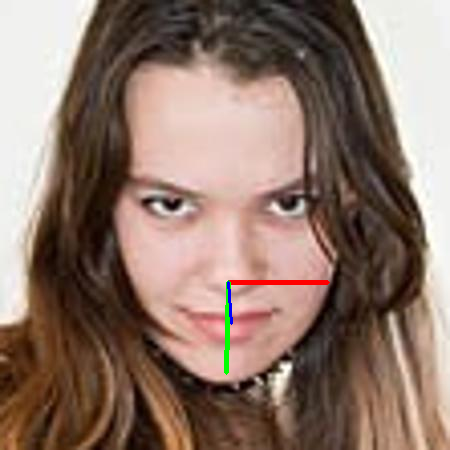

In [64]:
drawPos(test.index[0])

draw predicted poses

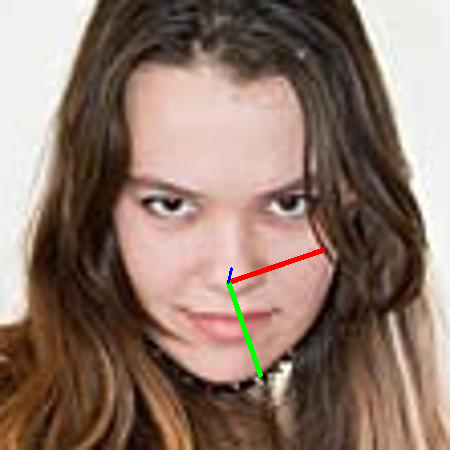

[0.132354640789734, -0.030540760378382454, -0.3289784339260433]


In [65]:
drawPos(test.index[0],customPose=preds[0].tolist())
print(preds[0].tolist())

Trying SVR

In [66]:
svr = MultiOutputRegressor(SVR(kernel='rbf', C=1))
svr.fit(train.iloc[:,:-3],train.iloc[:,:-4:-1])

MultiOutputRegressor(estimator=SVR(C=1))

In [67]:
preds =svr.predict(test.iloc[:,:-3])

In [68]:
r2_score(test.iloc[:,:-4:-1],preds)

0.8518623797912032

draw original poses

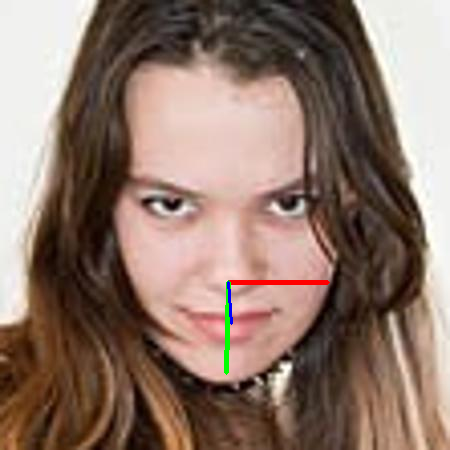

In [69]:
drawPos(test.index[0])

draw predicted poses

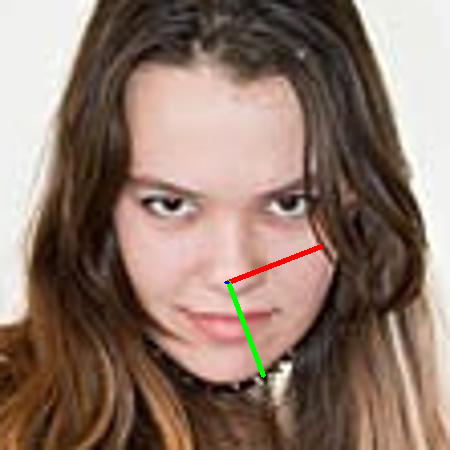

[0.07522039797643322, 0.2556263213439908, -0.09001604013131183]


In [70]:
drawPos(test.index[0],customPose=preds[0].tolist())
print(preds[9].tolist())

the performance is not too bad although the r2 score is not high, but it takes a very long time

#### Train model on data after PCA

In [71]:
train_pca,test_pca = train_test_split(data_pca,test_size=0.2,random_state=42)

In [72]:
model_pca = MultiOutputRegressor(AdaBoostRegressor(n_estimators=60,learning_rate=0.3))
model_pca.fit(train_pca.iloc[:,:-3],train_pca.iloc[:,:-4:-1])

MultiOutputRegressor(estimator=AdaBoostRegressor(learning_rate=0.3,
                                                 n_estimators=60))

In [73]:
preds_pca = model_pca.predict(test_pca.iloc[:,:-3])

In [74]:
r2_score(test_pca.iloc[:,:-4:-1],preds_pca)

-3.473355637026158

draw original poses

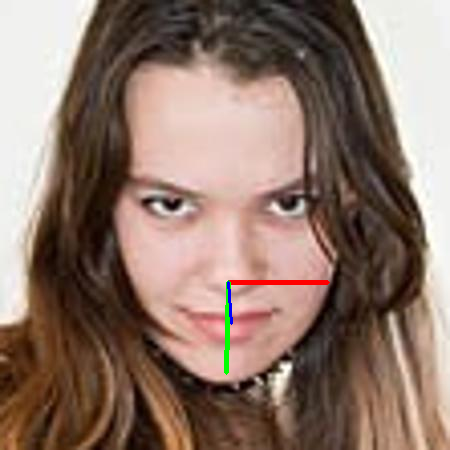

In [75]:
drawPos(test_pca.index[0])

draw predicted poses

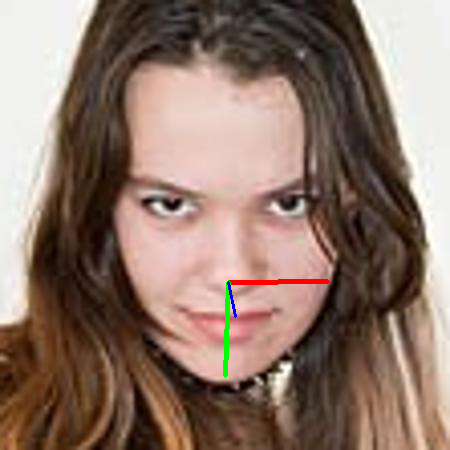

[-0.3534242983729815, -0.07353074394218823, 0.021656260165856957]


In [76]:
drawPos(test_pca.index[0],customPose=preds_pca[0].tolist())
print(preds_pca[0].tolist())

In [77]:
svr_pca = MultiOutputRegressor(SVR(kernel='rbf',epsilon=0.007))
svr_pca.fit(train_pca.iloc[:,:-3],train_pca.iloc[:,:-4:-1])

MultiOutputRegressor(estimator=SVR(epsilon=0.007))

In [78]:
preds_pca =svr_pca.predict(test_pca.iloc[:,:-3])

In [79]:
r2_score(test_pca.iloc[:,:-4:-1],preds_pca)

0.8519741063456431

draw original poses

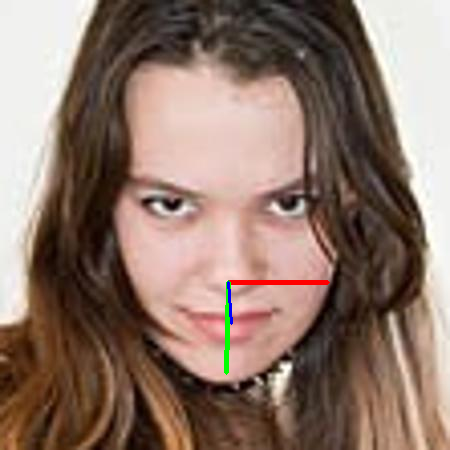

In [80]:
drawPos(test_pca.index[0])

draw predicted poses

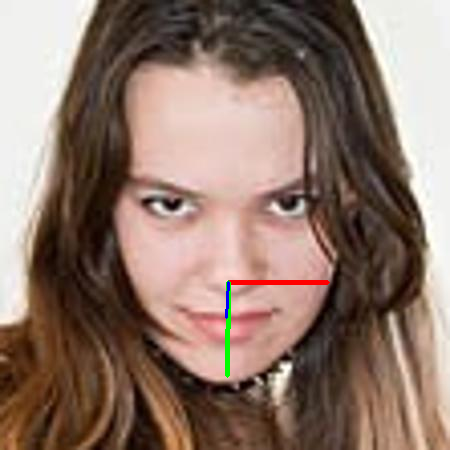

[-0.07415603484983865, 0.2790749566991528, 0.0943079432102453]


In [81]:

drawPos(test_pca.index[0],customPose=preds_pca[0].tolist())
print(preds_pca[9].tolist())

## Model Testing on New Data

In [82]:
  #try training random forest on all data
  rf_pca = MultiOutputRegressor(RandomForestRegressor(max_depth = 4,min_samples_split=4))
  rf_pca.fit(data_pca.iloc[:,:-3],data_pca.iloc[:,:-4:-1])


MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=4,
                                                     min_samples_split=4))

In [89]:
def prediction(name):
  if os.path.isfile('/content/drive/MyDrive/Head-pose tests/'+name+'.jpg') == False:
    print('x')
  landmarks = getLandMarks(name,None,path='/content/drive/MyDrive/Head-pose tests/')
  #print(sum(landmarks[0]),sum(landmarks[1]))
  landmarksX = []
  landmarksY = []
  landmarksX.append(landmarks[0])
  landmarksY.append(landmarks[1])
  drawPoints(name,path='/content/drive/MyDrive/Head-pose tests/')
  X = pd.DataFrame(landmarksX,columns=["x"+str(i) for i in range(1,469)])
  Y = pd.DataFrame(landmarksY,columns=["y"+str(i) for i in range(1,469)])
  to_pred = pd.concat([X,Y],axis=1)
  to_pred_pca = pd.DataFrame(pca.transform(pd.concat([X,Y],axis=1)))
  svr_pca = MultiOutputRegressor(SVR(kernel='rbf',epsilon=0.007))
  svr_pca.fit(data_pca.iloc[:,:-3],data_pca.iloc[:,:-4:-1])
  preds = svr_pca.predict(to_pred_pca)
  img = draw_axis(preds[0].tolist()[0],preds[0].tolist()[1],preds[0].tolist()[2],None,name=name,path='/content/drive/MyDrive/Head-pose tests/', tdx=None, tdy=None, size = 100)
  cv2_imshow(img)

  

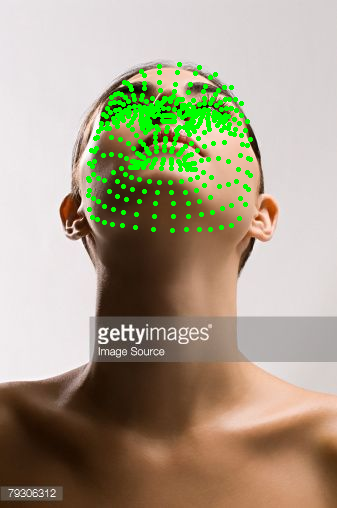

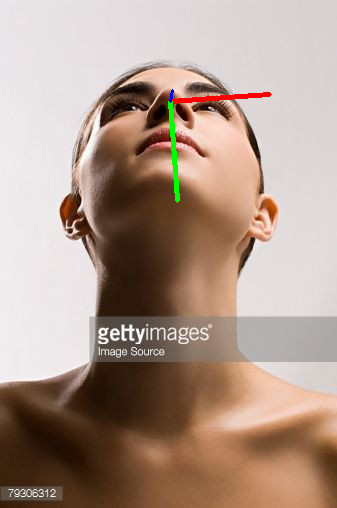

In [90]:
name = 'test9'
prediction(name)

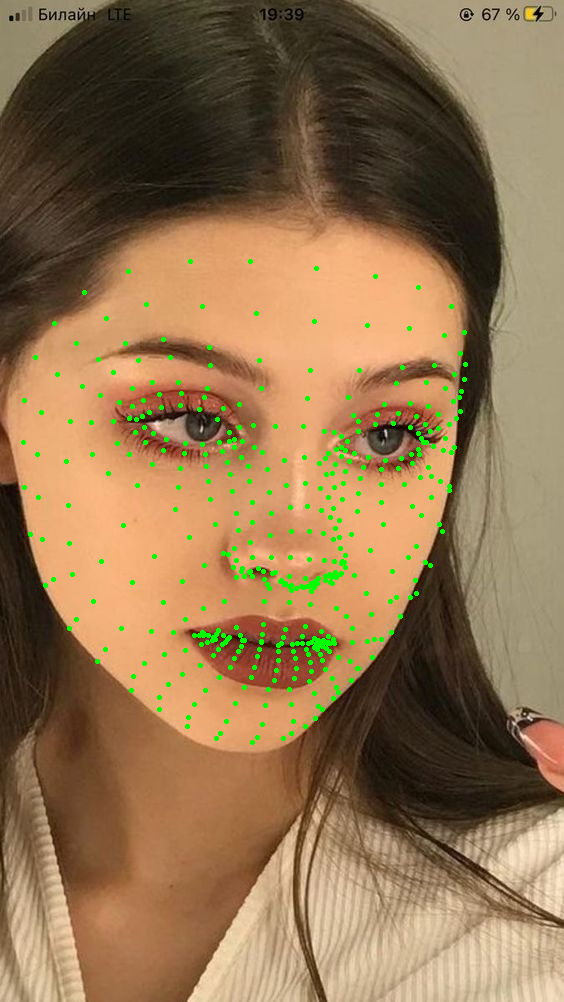

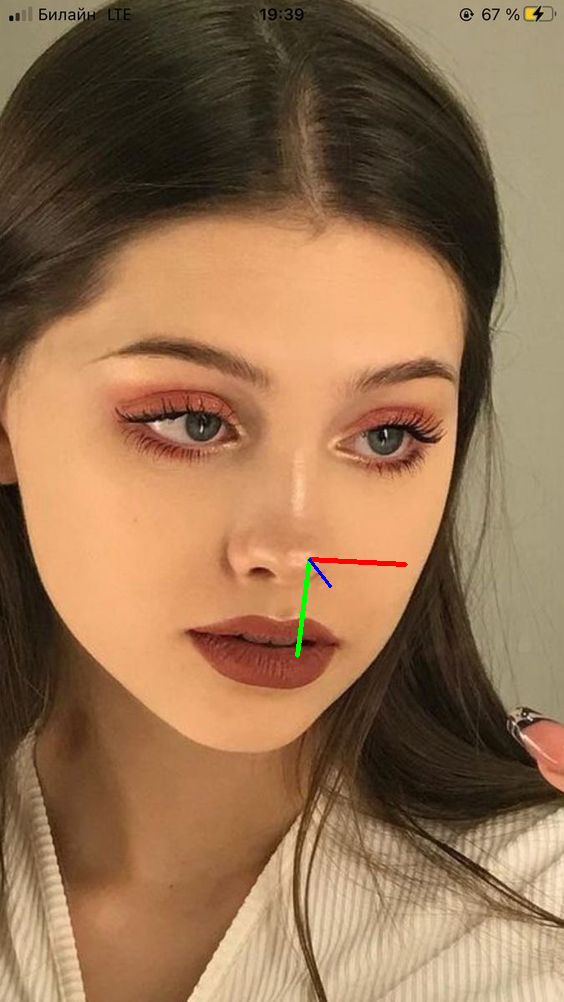

In [86]:
name = 'test6'
prediction(name)

## Model Testing on Video

In [ ]:
vidcap = cv2.VideoCapture('/content/drive/MyDrive/Head-pose tests/video2.mp4')

In [ ]:
frames=[]
success,image = vidcap.read()
count = 0
landmarksX = []
landmarksY = []
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  if(success):
    landmarks = getLandMarks(None,image)
    if(landmarks[0] == [] or landmarks[1] == []):
       continue
    landmarksX.append(landmarks[0])
    landmarksY.append(landmarks[1])
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    frames.append(image)
    count += 1


In [ ]:
X = pd.DataFrame(landmarksX,columns=["x"+str(i) for i in range(1,469)])
Y = pd.DataFrame(landmarksY,columns=["y"+str(i) for i in range(1,469)])
to_pred =pd.concat([X,Y],axis=1)
print(to_pred.isna().sum())
print(len(to_pred))
print(count)
to_pred_pca = pca.transform(to_pred)

x1      0
x2      0
x3      0
x4      0
x5      0
       ..
y464    0
y465    0
y466    0
y467    0
y468    0
Length: 936, dtype: int64
536
536


In [ ]:
preds = svr_pca.predict(to_pred_pca)
preds.shape

(536, 3)

In [ ]:
frames_out = []
for i in range(0,preds.shape[0],3):
  img = draw_axis(preds[i].tolist()[0],preds[i].tolist()[1],preds[i].tolist()[2],frames[i])
  frames_out.append(img)
  #cv2_imshow(img)

In [ ]:
print(len(frames_out))
w, h = frames[0].shape[0],frames[0].shape[1]
writer = cv2.VideoWriter('out.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 7, (h,w))
for frame in frames_out:
  writer.write(frame)
writer.release()

179
